# Классификация госконтрактов по объектам закупки

## Импорт библиотек

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('popular', quiet=True)

from catboost import CatBoost, CatBoostClassifier, Pool, cv

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

RANDOM_STATE = 42

from torch.cuda import get_device_name
get_device_name()

'Tesla V100-PCIE-32GB'

## Формирование выборок

Проведем обработку **category**, пропустив данные через функцию prepare_text, которая подготовит текст и выполнит стемминг.

In [2]:
stemmer = nltk.stem.SnowballStemmer(language='russian')
stopwords_ru = set(stopwords.words("russian"))

def prepare_text(text, stemmer=stemmer, stopwords=stopwords_ru):
    # Оставляем только слова
    text = re.sub(r"[^а-яё]", ' ', text.lower())
    # Проводим токенизацию, выделяя отдельные слова
    tokens = word_tokenize(text)
    # Удаляем не несущие смысла токены (стоп-слова)
    tokens = [t for t in tokens if not t in stopwords]
    # Запустим стемминг (нахождение основы слова)
    return ' '.join([stemmer.stem(t) for t in tokens])

Загрузим очищенный, подготовленный датафрейм если он есть иначе выполним **prepare_text**.

In [3]:
try:
    df = pd.read_parquet('../data/fzdata-nlp.parquet')
except:
    df = pd.read_parquet('../data/fzdata-clean.parquet')

    df['category_prep'] = df['category'].map(prepare_text)
    df.drop(['category'], axis=1, inplace=True)
    df.to_parquet('../data/fzdata-nlp.parquet')

print(df.shape)

(1865463, 8)


Разобьём выборку на тестовую и тренировочную.

In [4]:
X = df.drop(['target_group'], axis=1)
y = df['target_group']

# Так как выборка не сбалансированная указываем stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print(X_train.shape, X_test.shape)

(1492370, 7) (373093, 7)


In [5]:
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()
# Категориальные фичи
cat_features.remove('category_prep')
# Текстовые фичи
text_features = ['category_prep']

In [6]:
train_set = Pool(X_train, y_train, cat_features=cat_features, text_features=['category_prep'])
test_set = Pool(X_test, y_test, cat_features=cat_features, text_features=['category_prep'])

## Моделирование

Воспользуемся randomized_search для поиска оптимальных гиперпараметров. В качесте eval метрики возьмем [TotalF1](https://catboost.ai/en/docs/concepts/loss-functions-multiclassification#totalF1).

Альтернативной моделью можно было бы использовать логистическую регрессию как в приведенной [статье на habr](https://habr.com/ru/articles/584506/).
Она сложнее в реализации чем **CatBoostClassifier** и не имеет явных преимуществ, поэтому в работе она не рассматривается.

Для подбора параметров используется **randomized_search**, но можно было использовать **optuna** с `optuna.create_study(direction='minimize')`.

In [7]:
# Задаем начальные параметры
params={
    'task_type': 'GPU',
    'devices': '0:1',
    'random_seed': RANDOM_STATE,
    'objective': 'MultiClass',
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1:hints=skip_train~false',
    'early_stopping_rounds': 100, # чтобы не было переобучения модели
    'logging_level': 'Silent',
}

model = CatBoost(params=params)

# Формируем сетку параметров по которым будет проводится оптимизация
param_grid = {
    'depth': range(6,11,1), # используем рекомендуемый диапазон
    'bootstrap_type': ['Poisson', 'Bayesian'],
    'random_strength': np.linspace(0.7, 1, 11),
    'learning_rate': [0.001, 0.01],
}

# Запускаем поиск
search = model.randomized_search(
    param_grid,
    train_set,
    cv=5,
    n_iter=30,
    search_by_train_test_split=True,
    stratified=True,
    partition_random_seed=RANDOM_STATE,
    verbose=True,
)

# Обновляем параметры найденными оптимальными
params.update(search['params'])
search['params']

0:	loss: 0.6381733	best: 0.6381733 (0)	total: 27s	remaining: 13m 2s
1:	loss: 0.5839721	best: 0.6381733 (0)	total: 30.4s	remaining: 7m 5s
2:	loss: 0.6384059	best: 0.6384059 (2)	total: 45.3s	remaining: 6m 48s
3:	loss: 0.6382795	best: 0.6384059 (2)	total: 1m	remaining: 6m 35s
4:	loss: 0.6384059	best: 0.6384059 (2)	total: 1m 15s	remaining: 6m 17s
5:	loss: 0.6382795	best: 0.6384059 (2)	total: 1m 30s	remaining: 6m 2s
6:	loss: 0.6384059	best: 0.6384059 (2)	total: 1m 45s	remaining: 5m 47s
7:	loss: 0.5933759	best: 0.6384059 (2)	total: 1m 49s	remaining: 5m 1s
8:	loss: 0.6405260	best: 0.6405260 (8)	total: 2m 7s	remaining: 4m 56s
9:	loss: 0.5934246	best: 0.6405260 (8)	total: 2m 10s	remaining: 4m 21s
10:	loss: 0.5934246	best: 0.6405260 (8)	total: 2m 14s	remaining: 3m 52s
11:	loss: 0.6405260	best: 0.6405260 (8)	total: 2m 32s	remaining: 3m 48s
12:	loss: 0.6406156	best: 0.6406156 (12)	total: 2m 49s	remaining: 3m 42s
13:	loss: 0.5935790	best: 0.6406156 (12)	total: 2m 53s	remaining: 3m 18s
14:	loss: 0.5

{'random_strength': 0.94,
 'depth': 10,
 'bootstrap_type': 'Poisson',
 'learning_rate': 0.01}

Результаты модели на тренировочном датасете.

In [8]:
print('train-TotalF1-mean', search['cv_results']['train-TotalF1-mean'][-1])
print('test-TotalF1-mean', search['cv_results']['test-TotalF1-mean'][-1])
print('train-MultiClass-mean', search['cv_results']['train-MultiClass-mean'][-1])
print('test-MultiClass-mean', search['cv_results']['test-MultiClass-mean'][-1])
print()
print(model.best_score_)

train-TotalF1-mean 0.9587096761896181
test-TotalF1-mean 0.9589465892292178
train-MultiClass-mean 0.13248740097445819
test-MultiClass-mean 0.13209180787266833

{'learn': {'TotalF1': 0.9588247477238422, 'MultiClass': 0.13202529784838882}}


График влиянияние фичей на целевую переменную. Из него видно что текстовые данные и стоимость вносят максимальный вклад, в то время как status можно отбросить. Нужно учитывать, что в зависимости от выбранных гиперпараметров модели важность признаков может меняться.

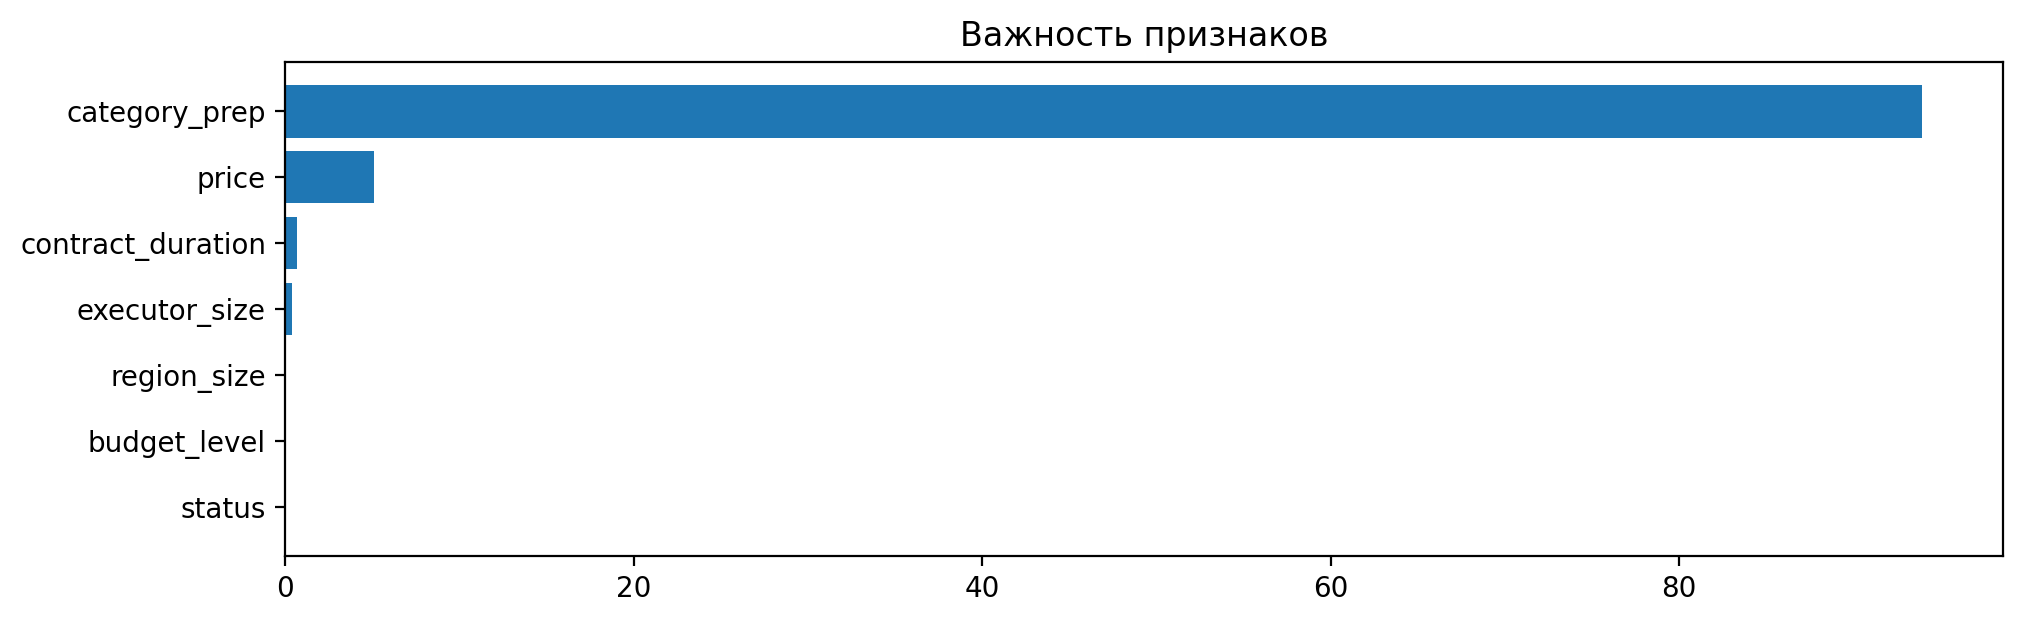

In [9]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 3))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Важность признаков')
plt.show()

Посмотрим какой результат покажет модель на тестовой выборке.

In [10]:
cbm = CatBoostClassifier(**params)
cbm.fit(train_set, verbose=250)
cbm.save_model("../data/model.cbm")

print(classification_report(y_test, cbm.predict(X_test)))

              precision    recall  f1-score   support

      ДРУГИЕ       0.95      0.94      0.94    112711
         ПИР       0.97      0.98      0.98    215208
         СМР       0.91      0.91      0.91     45174

    accuracy                           0.96    373093
   macro avg       0.94      0.94      0.94    373093
weighted avg       0.96      0.96      0.96    373093

